# Introduction
This notebook uses survey data collected from Dec 2022 to Mar 2023 on smartphone wellbeing feature awareness and usage. The CSV file used in this analysis has been deidentified and manipulated in Excel before being brough into Jupyter Notebooks.

# Data Setup

In [2]:
# import packages for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# import data
df = pd.read_csv('wellbeing_survey_responses.csv')
df.dropna(subset=['age'],inplace=True) #there is one row with all blanks including the age

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 353
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  353 non-null    int64  
 1   response_timestamp                  353 non-null    object 
 2   age                                 353 non-null    object 
 3   feature_learn_method                352 non-null    object 
 4   autonomy_avgscore                   345 non-null    float64
 5   competence_avgscore                 349 non-null    float64
 6   relatedness_avgscore                351 non-null    float64
 7   pressured_to_use_more               348 non-null    float64
 8   spend_more_time_than_should         351 non-null    float64
 9   makes_me_do_unwanted_things         350 non-null    float64
 10  life_intrusive                      352 non-null    float64
 11  more_ability_insecurity             351 non-n

## Data Encoding

In [4]:

# convert timestamp column from object to datetime data type
df['response_timestamp'] = pd.to_datetime(df['response_timestamp'])

# encode the ordinal age column to labels
age_ordinal_values = { 'Prefer not to answer': -1, '18 to 24 years': 1, '25 to 34 years': 2
                      , '35 to 44 years': 3, '45 to 54 years': 4, '55 to 64 years': 5,
                     '65+ years': 6}

df['age_encoded'] = df['age'].map(age_ordinal_values)

# encode the categorical feature learning column to one-hot encoding
flm_one_hot_df = pd.get_dummies(data=df['feature_learn_method'], prefix='flm', dummy_na=True)

df = pd.concat([df, flm_one_hot_df], axis=1)

# encode the categorical phone type column to iPhone flag, question was required in survey so data cannot be blank
def phone_type_mapping_func(ptype : str):
    if ptype == 'Prefer not to answer':
        return -1
    elif ptype == 'Apple iPhone':
        return 1
    else:
        return 0
    
df['iphone_flag'] = df['phone_type'].apply(phone_type_mapping_func)

# create a Categorical type column out of the age column which orders the age categories
age_order_list = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years'
, '55 to 64 years', '65+ years', 'Prefer not to answer']

df['age_categorical'] = pd.Categorical(df['age'], categories=age_order_list, ordered=True)

# coalesce the awareness and usage columns to one column for analysis
# source: https://www.statology.org/pandas-coalesce/
df['all_phone_feature_aware'] = df[['iphone_aware', 'samsung_aware', 'pixel_aware', 'other_aware']].bfill(axis=1).iloc[:, 0]
df['all_phone_feature_usage'] = df[['iphone_usage', 'samsung_usage', 'pixel_usage', 'other_usage']].bfill(axis=1).iloc[:, 0]

# encode the feature learn method column to a passive versus active flag column.
def active_learn_method_mapping_func(flm : str):
    if flm == 'OrganicUsage' or flm == 'AnotherPerson':
        return 0
    else:
        return 1
    
df['active_learn_method_flag'] = df['feature_learn_method'].apply(active_learn_method_mapping_func)

## Calculate ACTA Score

In [5]:

# Calculate the autonomous regulation score by getting the average score for questions that are
# intrinsic and identified motivated
intrinsic_identified_columns_list = ['expected_interesting_intrinsic', 'belief_life_improvement_identified'
                                     ,'help_do_important_identified', 'expect_enjoyable_intrinsic'
                                     , 'be_of_value_life_identified', 'fun_to_use_intrinsic']


df['autonomous_regulation_score'] = df[intrinsic_identified_columns_list].mean(axis=1)

In [6]:
# Calculate the controlled regulation score by getting the average score for questions that are
# external and introjected motivated
external_introjected_columns_list = ['others_want_me_use_external', 'others_know_usage_introjected'
                                     ,'feel_bad_not_trying_introjected', 'required_usage_external'
                                     , 'pressure_usage_external', 'look_good_others_introjected']


df['controlled_regulation_score'] = df[external_introjected_columns_list].mean(axis=1)

In [7]:
# Calculate relative autonomy index (RAI) by subtracting the average for Controlled Regulation
# from the average for Autonomous Regulation
df['relative_autonomy_index'] = df['autonomous_regulation_score'] - df['controlled_regulation_score']

In [8]:
df.columns

Index(['ID', 'response_timestamp', 'age', 'feature_learn_method',
       'autonomy_avgscore', 'competence_avgscore', 'relatedness_avgscore',
       'pressured_to_use_more', 'spend_more_time_than_should',
       'makes_me_do_unwanted_things', 'life_intrusive',
       'more_ability_insecurity', 'less_capable', 'lowered_confidence',
       'belonging_to_community', 'close_connect_important_persons',
       'close_to_some', 'phone_type', 'awareness_flag', 'awareness_count',
       'usage_flag', 'usage_count', 'others_want_me_use_external',
       'expected_interesting_intrinsic', 'belief_life_improvement_identified',
       'help_do_important_identified', 'others_know_usage_introjected',
       'feel_bad_not_trying_introjected', 'expect_enjoyable_intrinsic',
       'required_usage_external', 'be_of_value_life_identified',
       'fun_to_use_intrinsic', 'pressure_usage_external',
       'look_good_others_introjected', 'iphone_aware', 'iphone_usage',
       'pixel_aware', 'pixel_usage', 'oth

# Descriptive Statistics

In [9]:
# Helper function to print distribution count and percentages of total for columns
def print_column_value_counts(column):
    print(df[column].value_counts(), '\n')
    print(df[column].value_counts(normalize=True))

In [10]:
# Helper function to create a basic seaborn displot historgram for a column
def create_displot_from_column(column_x_value):
    displot = sns.displot(data=df, x=column_x_value)
    displot.set_xticklabels(rotation=45, ha='right')
    return displot

## Age Only

### How many surveyed participants in each age group?

In [46]:
print_column_value_counts(['age'])

age                 
25 to 34 years          117
18 to 24 years           74
35 to 44 years           49
65+ years                45
45 to 54 years           33
55 to 64 years           31
Prefer not to answer      4
dtype: int64 

age                 
25 to 34 years          0.331445
18 to 24 years          0.209632
35 to 44 years          0.138810
65+ years               0.127479
45 to 54 years          0.093484
55 to 64 years          0.087819
Prefer not to answer    0.011331
dtype: float64


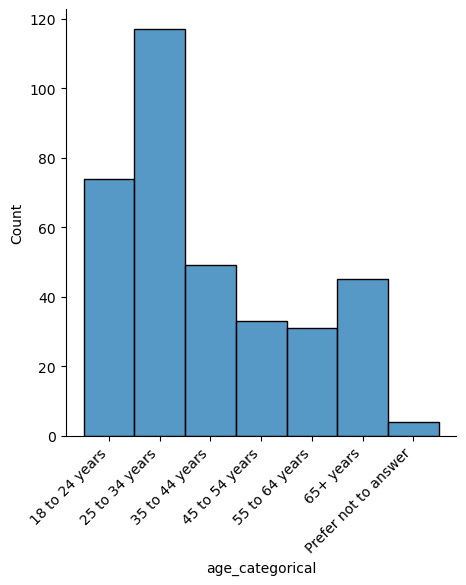

In [16]:
create_displot_from_column('age_categorical')
#age_displot = sns.displot(data=df, x='age_categorical')
#age_displot.set_xticklabels(rotation=45, ha='right')

## Feature Learn Method Only

### How do surveyed participants typically learn about smartphone features?

In [69]:
print_column_value_counts(['feature_learn_method'])

OrganicUsage         154
AnotherPerson        114
Proactive             43
SearchAfterUpdate     39
CompanyEmail           2
Name: feature_learn_method, dtype: int64 

OrganicUsage         0.437500
AnotherPerson        0.323864
Proactive            0.122159
SearchAfterUpdate    0.110795
CompanyEmail         0.005682
Name: feature_learn_method, dtype: float64


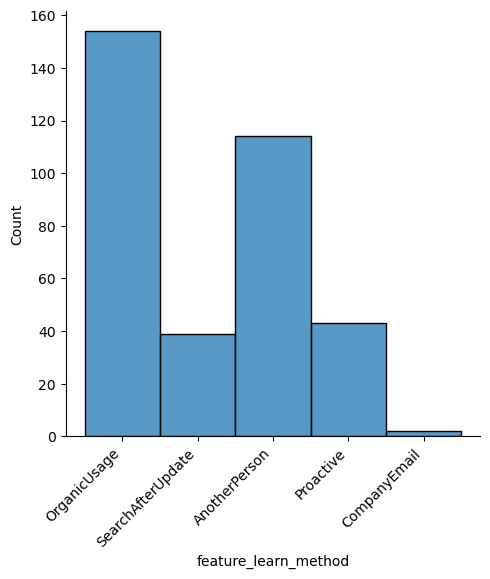

In [17]:
create_displot_from_column('feature_learn_method')

## Phone Type Only

### What types of smartphones were surveyed?

In [11]:
print_column_value_counts(['phone_type'])

phone_type          
Apple iPhone            247
Samsung                  62
Google Pixel             19
Motorola                  7
OnePlus                   7
Xiaomi                    4
Huawei                    2
Asus                      1
LG Nexus                  1
Prefer not to answer      1
Sony                      1
Xperia                    1
dtype: int64 

phone_type          
Apple iPhone            0.699717
Samsung                 0.175637
Google Pixel            0.053824
Motorola                0.019830
OnePlus                 0.019830
Xiaomi                  0.011331
Huawei                  0.005666
Asus                    0.002833
LG Nexus                0.002833
Prefer not to answer    0.002833
Sony                    0.002833
Xperia                  0.002833
dtype: float64


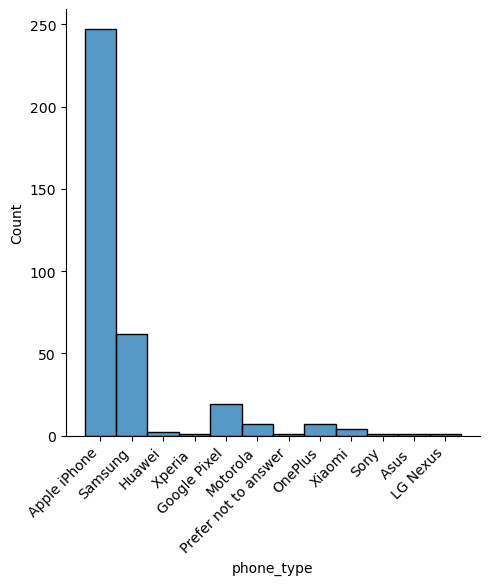

In [18]:
create_displot_from_column('phone_type')

## Awareness/Usage

### How many people were aware of smartphone wellbeing feature?

In [43]:
df['awareness_flag'].sum()

304

In [21]:
awareness_total = df['awareness_flag'].sum()
awareness_percentage = awareness_total / df['awareness_flag'].count()
print('Total number of people aware of wellbeing features =', awareness_total)
print('Percentage of people aware of wellbeing features =', awareness_percentage)

Total number of people aware of wellbeing features =  304
Percentage of people aware of wellbeing features =  86.11898016997166


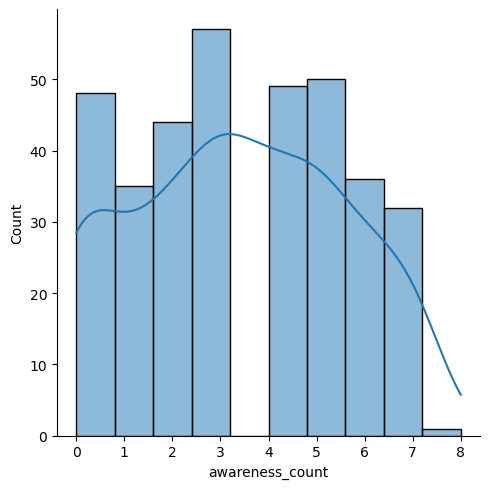

In [35]:
sns.displot(data=df, x='awareness_count', kde=True)

### What is the average, median, and mode for smarphone wellbeing feature awareness count?

In [32]:
print_column_value_counts(['awareness_count'])

awareness_count
3.0                57
5.0                50
4.0                49
0.0                48
2.0                44
6.0                36
1.0                35
7.0                32
8.0                 1
dtype: int64 

awareness_count
3.0                0.161932
5.0                0.142045
4.0                0.139205
0.0                0.136364
2.0                0.125000
6.0                0.102273
1.0                0.099432
7.0                0.090909
8.0                0.002841
dtype: float64


In [40]:
print('Awareness mean =', df['awareness_count'].mean())
print('Awareness median =', df['awareness_count'].median())
print('Awareness mode =', df['awareness_count'].mode()[0])

Awareness mean = 3.375
Awareness median = 3.0
Awareness mode = 3.0


See Google Form for images of how many of each feature was checked

### How many people use smartphone wellbeing features?

In [46]:
print('Number of people aware of at least one wellbeing feature =', df['usage_flag'].sum())


Number of people aware of at least one wellbeing feature = 251


### What is the average, median, and mode for smartphone wellbeing feature usage count?

In [47]:
usage_total = df['usage_flag'].sum()
usage_percentage = usage_total / df['usage_flag'].count()
print('Total number of people who use at least one wellbeing feature =', usage_total)
print('Percentage of people who use at least one wellbeing feature =', usage_percentage)

Total number of people who use at least one wellbeing feature = 251
Percentage of people who use at least one wellbeing feature = 0.7110481586402266


In [11]:
print('Usage mean =', df['usage_count'].mean())
print('Usage median =', df['usage_count'].median())
print('Usage mode =', df['usage_count'].mode()[0])

Usage mean = 1.4176136363636365
Usage median = 1.0
Usage mode = 1.0


In [12]:
print_column_value_counts(['usage_count'])

usage_count
1.0            116
0.0            101
2.0             67
3.0             41
4.0             13
5.0             10
6.0              4
dtype: int64 

usage_count
1.0            0.329545
0.0            0.286932
2.0            0.190341
3.0            0.116477
4.0            0.036932
5.0            0.028409
6.0            0.011364
dtype: float64


## Combinations

### Age vs Feature Learn Method

In [66]:
df.groupby('age_categorical')['feature_learn_method'].value_counts(normalize=True)

age_categorical       feature_learn_method
18 to 24 years        OrganicUsage            0.527027
                      AnotherPerson           0.283784
                      Proactive               0.094595
                      SearchAfterUpdate       0.081081
                      CompanyEmail            0.013514
25 to 34 years        OrganicUsage            0.470085
                      AnotherPerson           0.273504
                      SearchAfterUpdate       0.153846
                      Proactive               0.094017
                      CompanyEmail            0.008547
35 to 44 years        OrganicUsage            0.387755
                      AnotherPerson           0.285714
                      Proactive               0.183673
                      SearchAfterUpdate       0.142857
45 to 54 years        OrganicUsage            0.437500
                      AnotherPerson           0.312500
                      Proactive               0.125000
                      

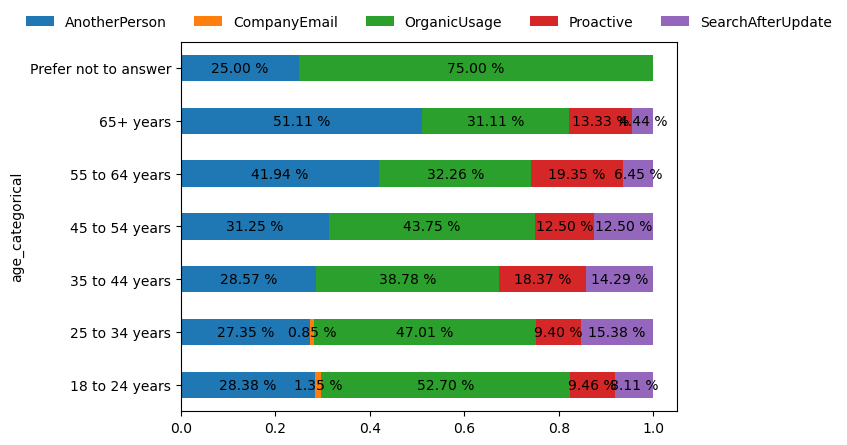

In [23]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df.groupby('age_categorical')['feature_learn_method'].value_counts(normalize=True).unstack('feature_learn_method')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=5,
)

for age_index, flm in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flm:
        if np.isnan(element):
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                age_index,
                f"{element * 100:.1f} %",
                va="center",
                ha="center",
            )
        cumulative += element

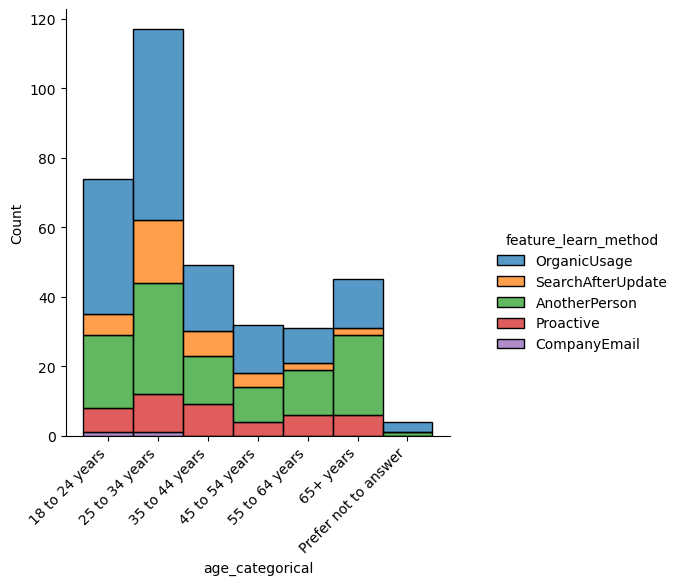

In [40]:
# stacked 100% bar chart
# chi-square test
# maybe combining the the FLM to passive vs active
chart = sns.displot(data=df, x='age_categorical', hue='feature_learn_method', multiple='stack')
chart.set_xticklabels(rotation=45, ha='right')
plt.show()

### Age vs Smartphone Type

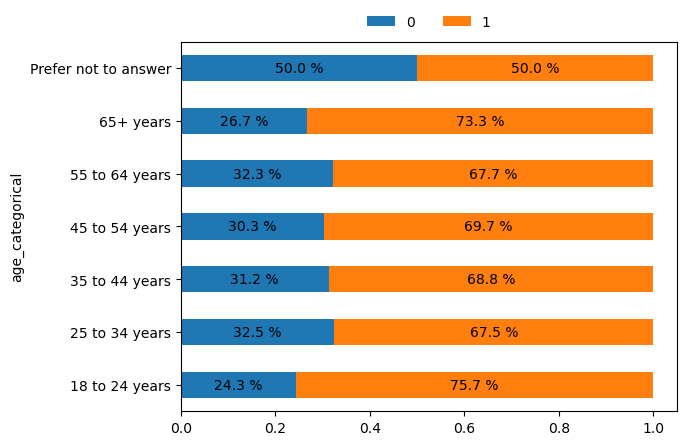

In [37]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df[df['iphone_flag'] >= 0].groupby('age_categorical')['iphone_flag'].value_counts(normalize=True).unstack('iphone_flag')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=2,
)

for age_index, flag in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flag:
        if np.isnan(element) or element < 0:
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                age_index,
                f"{element * 100:.1f} %",
                va="center",
                ha="center",
            )
        cumulative += element

### Smartphone Type vs Feature Learn Method

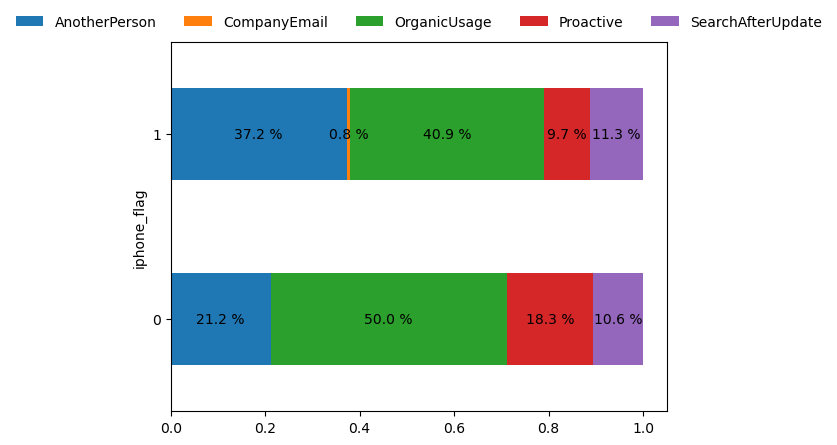

In [13]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df[df['iphone_flag'] >= 0].groupby('iphone_flag')['feature_learn_method'].value_counts(normalize=True).unstack('feature_learn_method')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=5,
)

for iphone_flag, flm in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flm:
        if np.isnan(element) or element < 0:
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                iphone_flag,
                f"{element * 100:.1f} %",
                va="center",
                ha="center",
            )
        cumulative += element

# Other

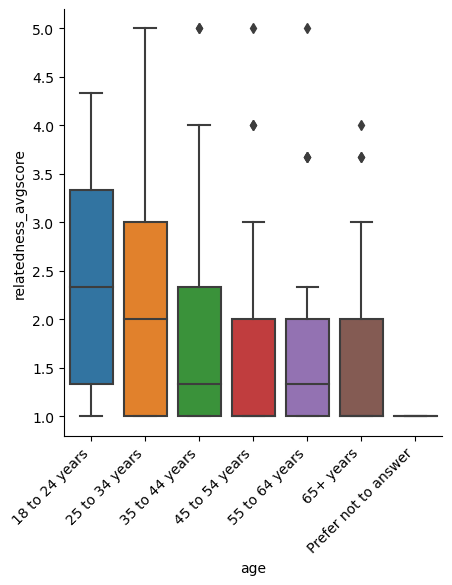

In [50]:
relatedness_age_boxplot = sns.catplot(data=df, x='age', y='relatedness_avgscore', kind='box', order=age_order_list)
relatedness_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

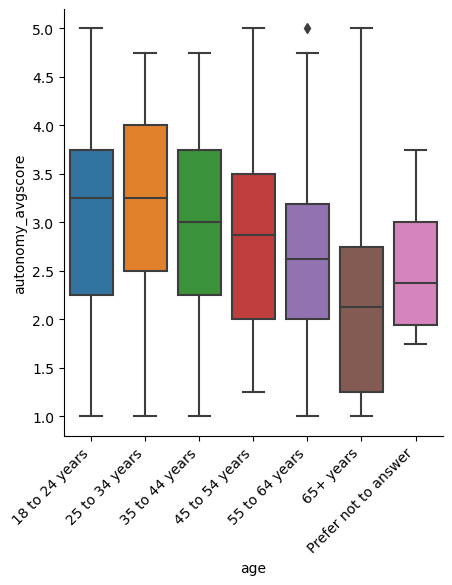

In [49]:
automony_age_boxplot = sns.catplot(data=df, x='age', y='autonomy_avgscore', kind='box', order=age_order_list)
automony_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

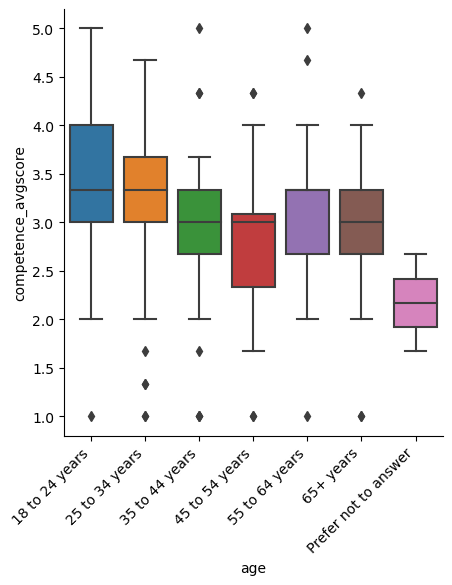

In [60]:
competence_age_boxplot = sns.catplot(data=df, x='age', y='competence_avgscore', kind='box', order=age_order_list)
competence_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

In [ ]:
sns.displot(data=df, x='autonomy_avgscore', kde=True)

# RQ1
What extent does smartphone usage impact perceive psychological wellbeing?

## What is the overall perceived psychological wellbeing of the surveyed population?

Mean relatedness score = 3.7951282051282047


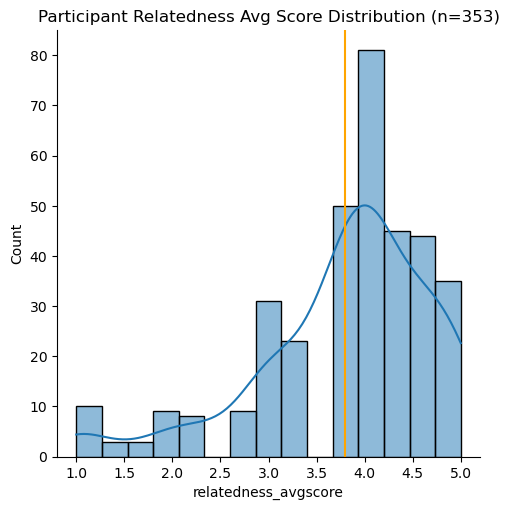

In [35]:
# Positive scoring. Higher the number the more feeling of relatedness
print('Mean relatedness score =', df['relatedness_avgscore'].mean())

sns.displot(data=df, x='relatedness_avgscore', kde=True)
plt.title('Participant Relatedness Avg Score Distribution (n=353)')
plt.axvline(df['relatedness_avgscore'].mean(), color='orange')

Mean competence score = 1.9597134670487104


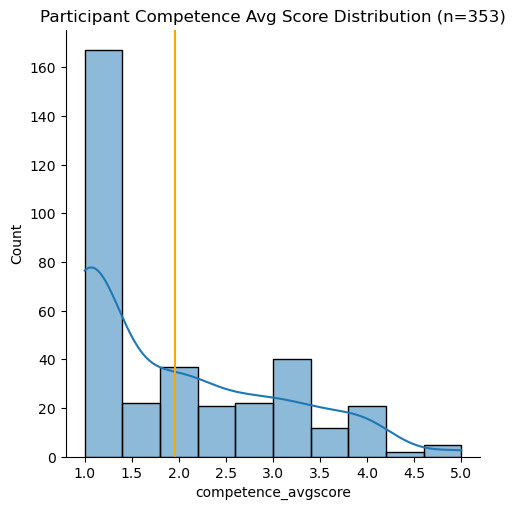

In [37]:
# Negative scoring. The lower the number the more feeling of competence
print('Mean competence score =', df['competence_avgscore'].mean())

sns.displot(data=df, x='competence_avgscore', kde=True)
plt.title('Participant Competence Avg Score Distribution (n=353)')
plt.axvline(df['competence_avgscore'].mean(), color='orange')

Mean competence score = 2.8956521739130436


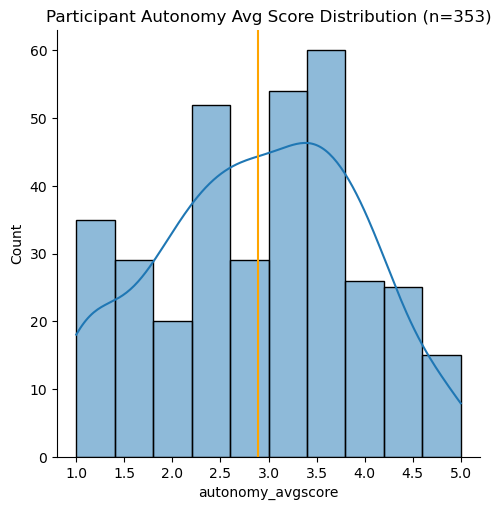

In [38]:
# Negative scoring. the lower the number the more feeling of autonomy
print('Mean competence score =', df['autonomy_avgscore'].mean())

sns.displot(data=df, x='autonomy_avgscore', kde=True)
plt.title('Participant Autonomy Avg Score Distribution (n=353)')
plt.axvline(df['autonomy_avgscore'].mean(), color='orange')

## What is the perceived psychological wellbeing by age?

In [20]:
# remove "Prefer not to answer" (pnta) responses from analysis
no_age_pnta_df = df[df['age_encoded'] > 0]

25 to 34 years    117
18 to 24 years     74
35 to 44 years     49
65+ years          45
45 to 54 years     33
55 to 64 years     31
Name: age, dtype: int64

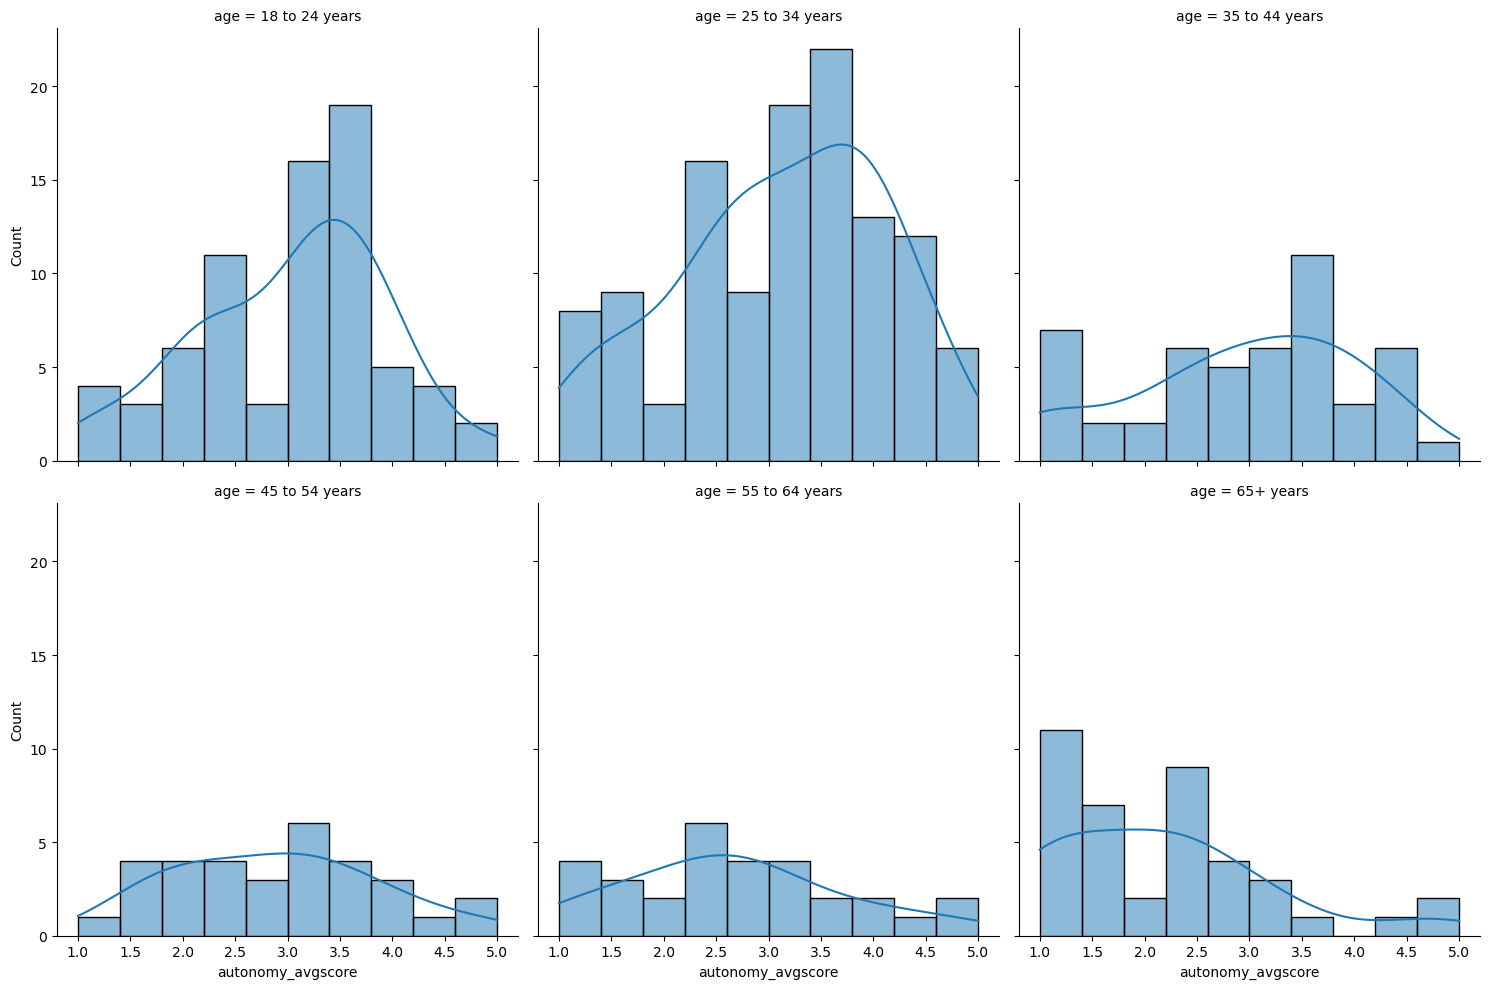

In [21]:
# Negative scoring. The lower the number the more feeling of autonomy
age_col_order = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 64 years', '65+ years']
autonomyplot = sns.displot(data=no_age_pnta_df, x='autonomy_avgscore', kde=True, col='age', col_order=age_col_order, col_wrap=3)

# 18 to 44 years old are leaning towards feeling less autonomous compared to the 45 to 65 years old populations

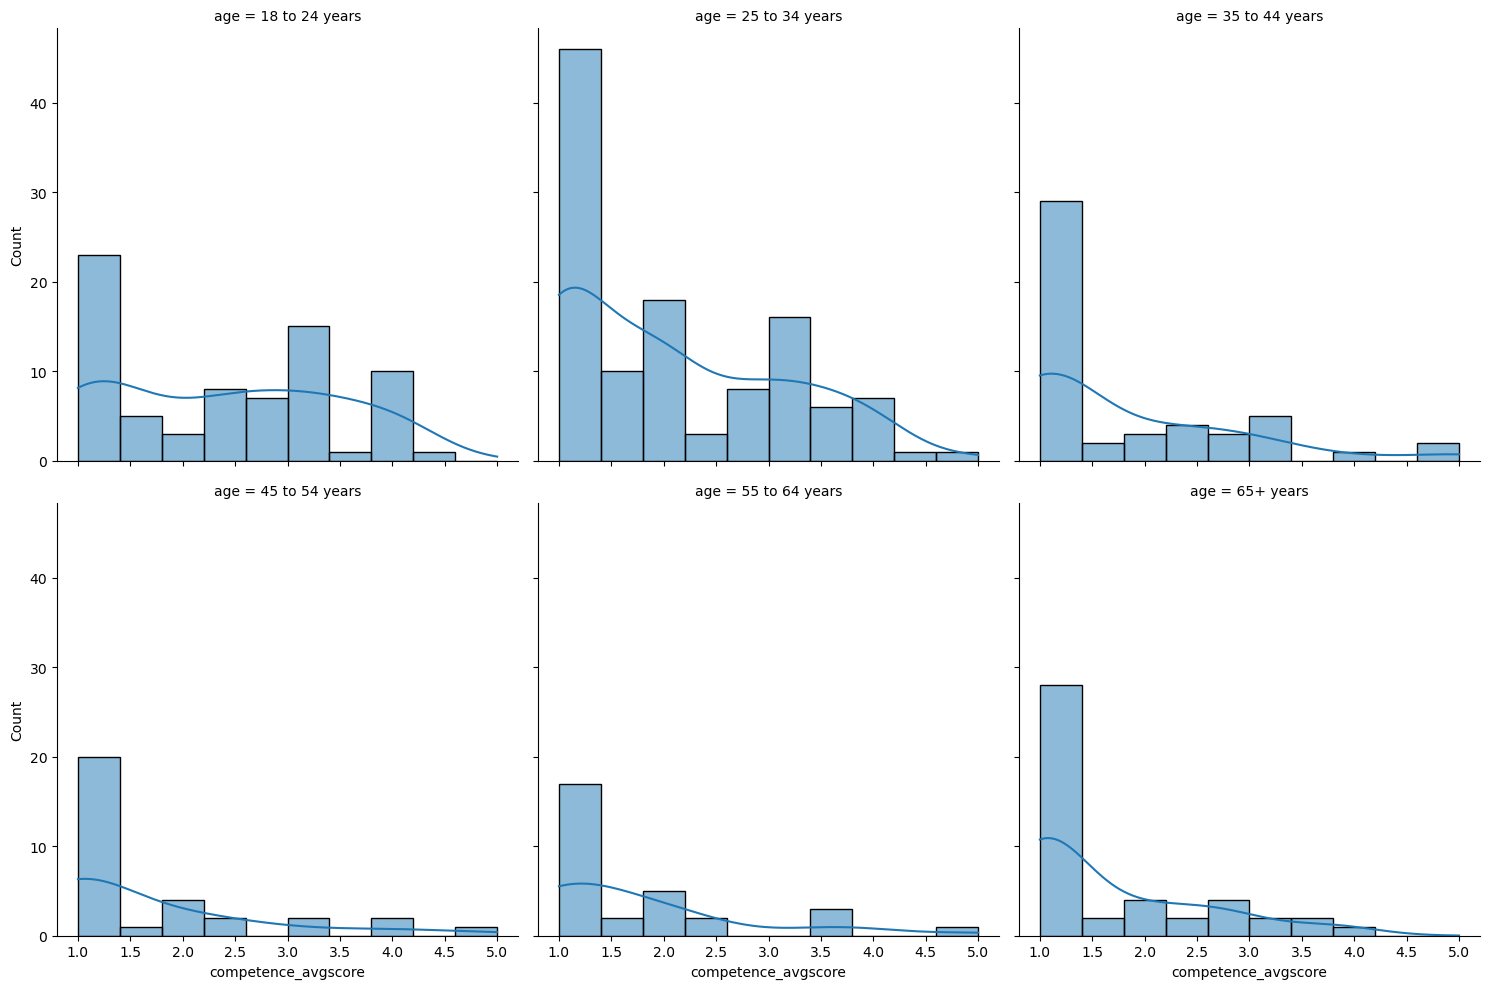

In [22]:
# Negative scoring. The lower the number the more feeling of competence
competenceplot = sns.displot(data=no_age_pnta_df, x='competence_avgscore', kde=True, col='age', col_order=age_col_order, col_wrap=3)
# 18 to 34 years old population mostly feels competent, but has more variation than 35+ populations

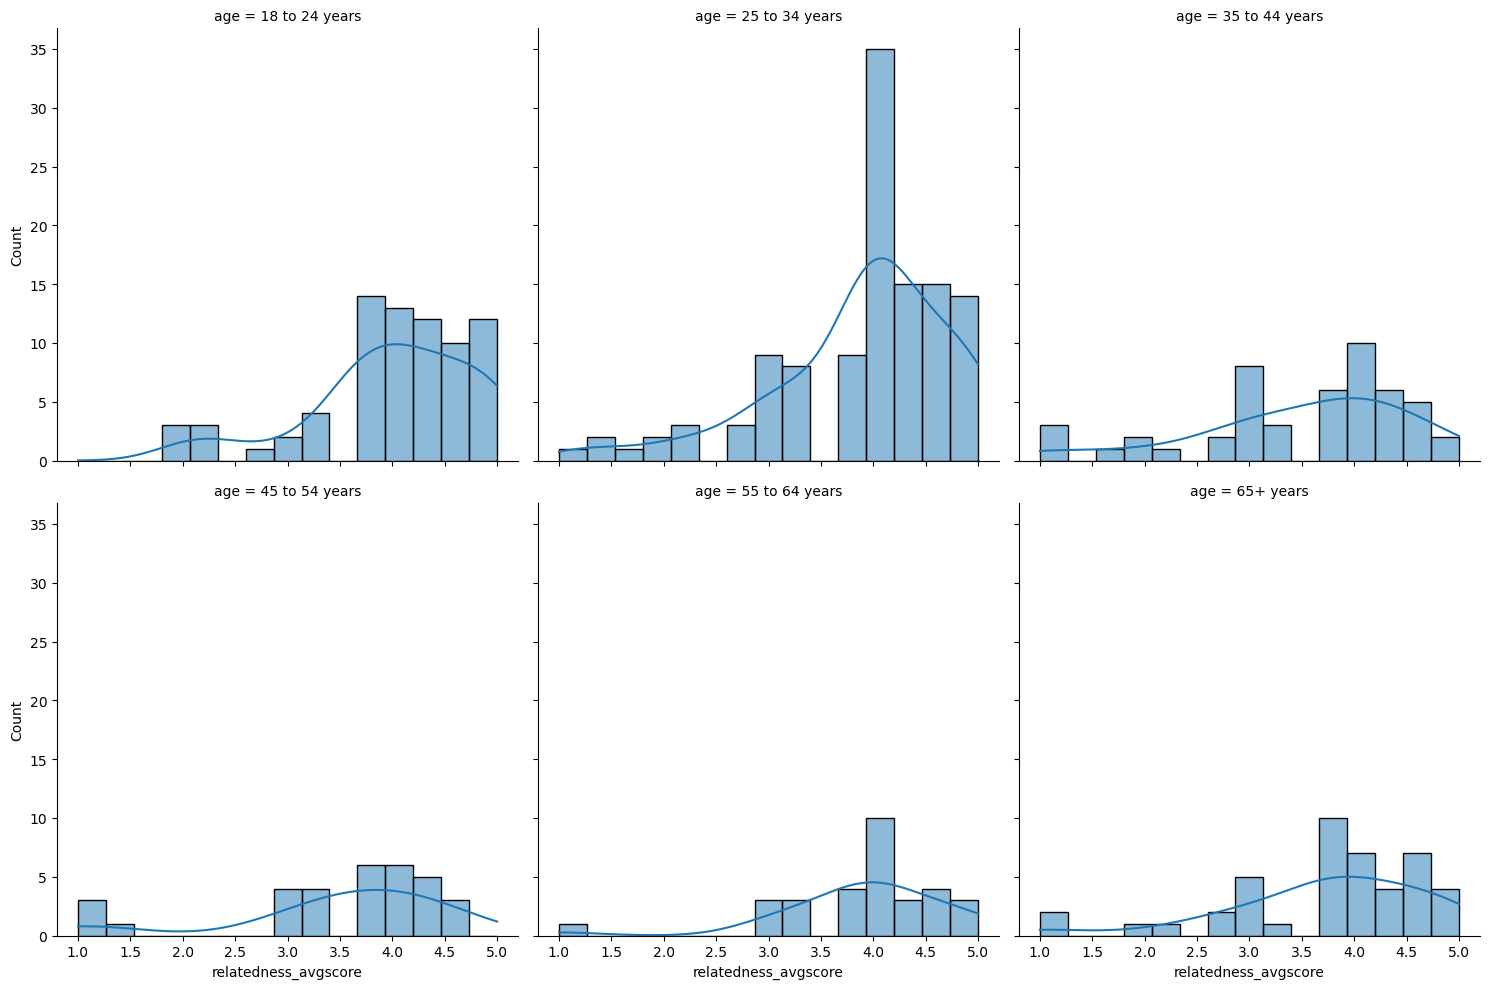

In [23]:
# Positive scoring. The higher the number the more feeling of relatedness
relatednessplot = sns.displot(data=no_age_pnta_df, x='relatedness_avgscore', kde=True, col='age', col_order=age_col_order, col_wrap=3)
# All age groups show higher relatedness scores meaning more feelings of relatedess due to smartphone usage

## What is the perceived psychological wellbeing of iPhone versus Android users?

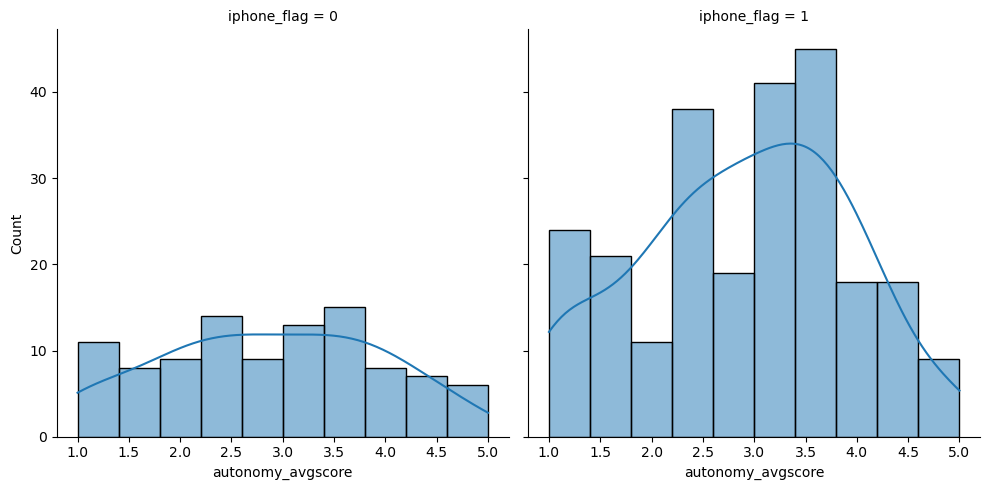

In [27]:
# Negative scoring. The lower the number the more feeling of autonomy
no_phone_pnta_df = df[df['iphone_flag'] >= 0]

sns.displot(data=no_phone_pnta_df, x='autonomy_avgscore', kde=True, col='iphone_flag')
# Android users
# t-test

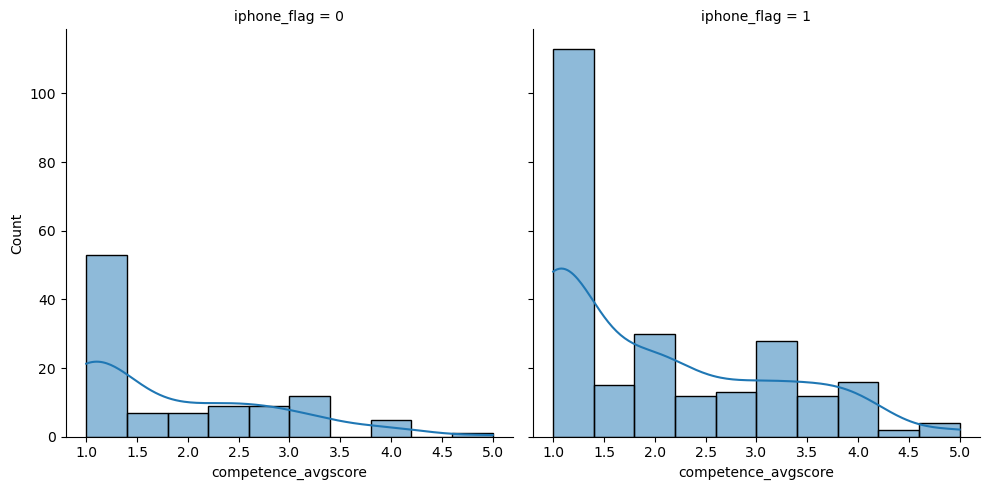

In [28]:
# Negative scoring. The lower the number the more feeling of competence
sns.displot(data=no_phone_pnta_df, x='competence_avgscore', kde=True, col='iphone_flag')
# Android users

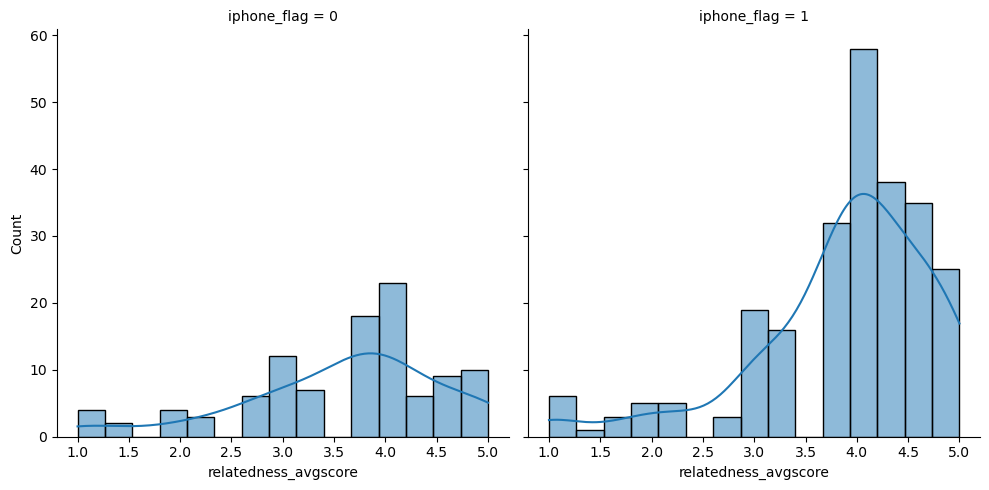

In [29]:
# Positive scoring. The higher the number the more feeling of relatedness
sns.displot(data=no_phone_pnta_df, x='relatedness_avgscore', kde=True, col='iphone_flag')
# Android users

# RQ2
How aware of and widely used are smartphone features aimed to support wellbeing?

## Does age affect how one learns about smartphone features in general?
Hypothesis: Younger populations are more likely to be proactive about learning features on their smartphone in general

## Active learners of features are more likely to be aware of wellbeing features compared to passive leaners

In [96]:
ct = pd.crosstab(df['active_learn_method_flag'], df['awareness_flag'])
ct
# passive/unaware, passive/aware
# active/unaware, active/aware

awareness_flag,0,1
active_learn_method_flag,,
0,45,223
1,4,81


In [97]:
# Null hypothesis - active learners and passive learners have the same probability in their awareness of wellbeing features
# Alternative hypothesis - active learners are more likey to be aware than passive learners of wellbeing features
# p-value of less than 0.05 for significance

# Not all values are at least 5 so we cannot use chi-square test

# Use Barnard exact https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.barnard_exact.html#scipy.stats.barnard_exact
ber = stats.barnard_exact(table=ct, alternative='greater')
print(ber)

# active learners are more likey to be aware than passive learners of wellbeing features

BarnardExactResult(statistic=2.8079015228830455, pvalue=0.010025422201176078)


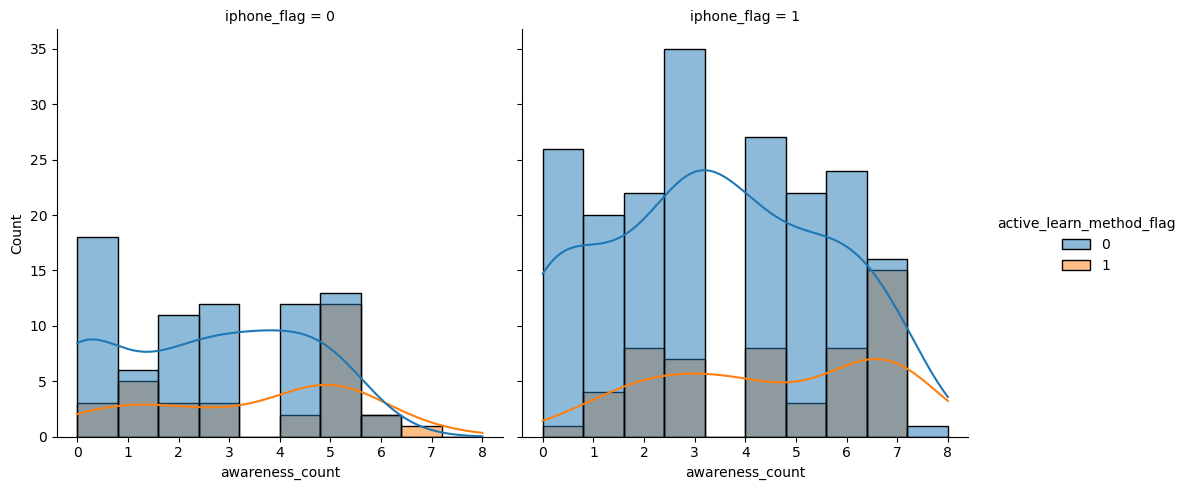

In [79]:
sns.displot(data=no_phone_pnta_df, x='awareness_count', hue='active_learn_method_flag', col='iphone_flag', kde=True)

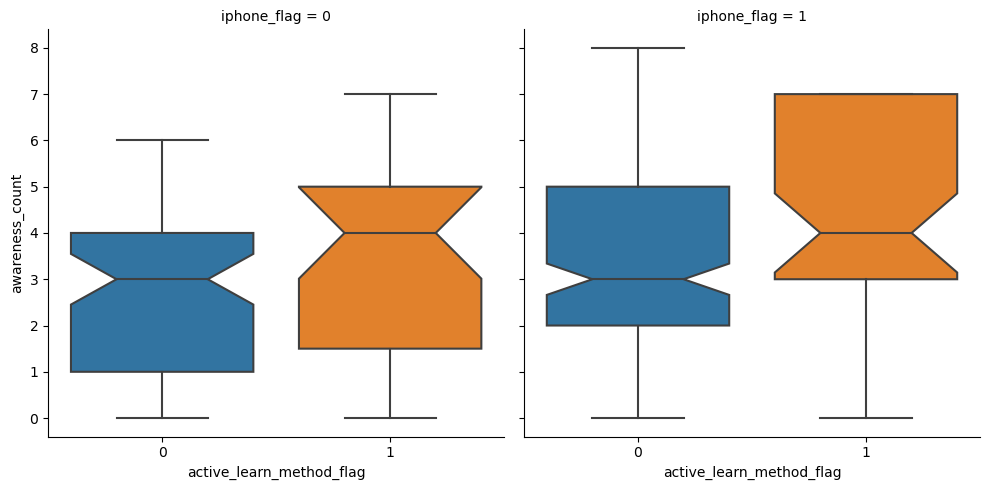

In [80]:
# Examine if active learners know about more features than passive learners
# Null hypothesis - The distribution awareness counts for active and passive learners are the same
# Alternative hypothesis - Active learners are aware of more features than passive learners
# p-value of less than 0.05 for significance

learn_method_boxplot = sns.catplot(data=no_phone_pnta_df, x='active_learn_method_flag', y='awareness_count', col='iphone_flag', kind='box', notch=True)
#relatedness_age_boxplot.set_xticklabels(rotation=45, ha='right')
#plt.show()


In [83]:
# Examine if active learners know about more features than passive learners
# Null hypothesis - The distribution awareness counts for active and passive learners are the same
# Alternative hypothesis - Active learners are aware of more features than passive learners
# p-value of less than 0.05 for significance

# Data not normally distributed so use Mann Whitney instead fo T-Test
from scipy.stats import mannwhitneyu

iphone_user_df = df[df['iphone_flag'] == 1]
android_user_df = df[df['iphone_flag'] == 0]

iphone_passive_learn = iphone_user_df[iphone_user_df['active_learn_method_flag'] == 0]['awareness_count']
iphone_acitve_learn = iphone_user_df[iphone_user_df['active_learn_method_flag'] == 1]['awareness_count']
android_passive_learn = android_user_df[android_user_df['active_learn_method_flag'] == 0]['awareness_count']
android_active_learn = android_user_df[android_user_df['active_learn_method_flag'] == 1]['awareness_count']

# Since we hypothesize that passive learners are aware of less features than active learners, we choose alternative less
mannwhitney_iphone = mannwhitneyu(iphone_passive_learn, iphone_acitve_learn, alternative='less')
mannwhitney_android = mannwhitneyu(android_passive_learn, android_active_learn, alternative='less')

print('iPhone Mann Whitney=', mannwhitney_iphone)
print('Android Mann Whitney=', mannwhitney_android)

# statistically significant difference between active and passive learners for awareness count and that active learners are aware of more features

iPhone Mann Whitney= MannwhitneyuResult(statistic=3783.5, pvalue=0.0019275907865509017)
Android Mann Whitney= MannwhitneyuResult(statistic=838.5, pvalue=0.02800722897952329)


## Is wellbeing feature awareness correlated with usage?

In [95]:
awareness_usage_ct = pd.crosstab(df['awareness_flag'], df['usage_flag'])
awareness_usage_ct

# unaware/no usage, unaware/usage (this should be zero?)
# aware/no usage, aware/usage

usage_flag,0,1
awareness_flag,,
0,44,5
1,58,246


In [101]:
# Null hypothesis - Awareness of features and usage are not related
# Alternative hypothesis - Awareness of features and usage are related
# p-value of less than 0.05 for significance

# Use Chi-square test of independence
au_chi2 = stats.chi2_contingency(awareness_usage_ct)
print(f'Chi^2 statistic= {au_chi2[0]}, p-value= {au_chi2[1]}, degree of freedom = {au_chi2[2]}')

# Chi-square distribution table https://www.scribbr.com/statistics/chi-square-distribution-table/
# Right-tailed chi-square critical value for 1 df and 0.05 p-value is 3.841
# 99.298121 > 3.841
# We can accept the alternative hypothesis that awareness of features and usage are related

Chi^2 statistic= 99.29812144571079, p-value= 2.172139951890496e-23, degree of freedom = 1


## Does the type of smartphone used affect awareness or usage of wellbeing features?

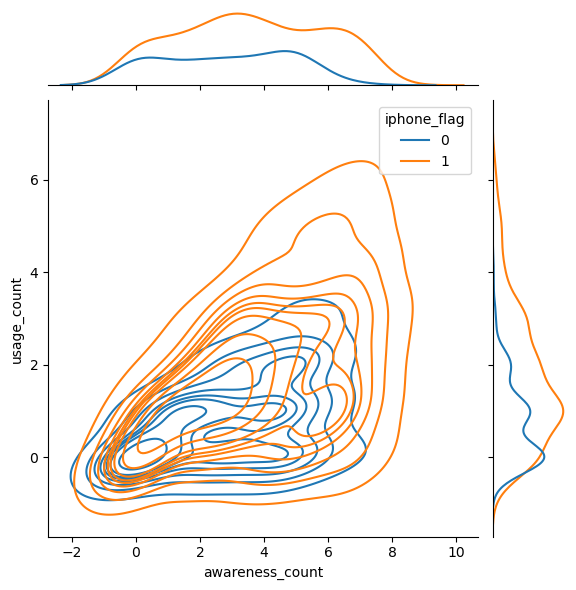

In [112]:
sns.jointplot(data=no_phone_pnta_df, x='awareness_count', y='usage_count', hue='iphone_flag', kind='kde')
# The awarenss of features is variable, but the usage of wellbeing is centralized to two or less for android and iphone
# The distribution of iphone awareness and usage is greater than android. So what? iPhone users

# RQ3

In [203]:
print(df[df['usage_flag'] == 0]['autonomy_avgscore'].shape)
print(df[df['usage_flag'] == 1]['autonomy_avgscore'].shape)

(102,)
(251,)


### Autonomy

Wellbeing no usage mean autonomy score = 2.7551020408163267
Wellbeing usage mean autonomy score = 2.951417004048583


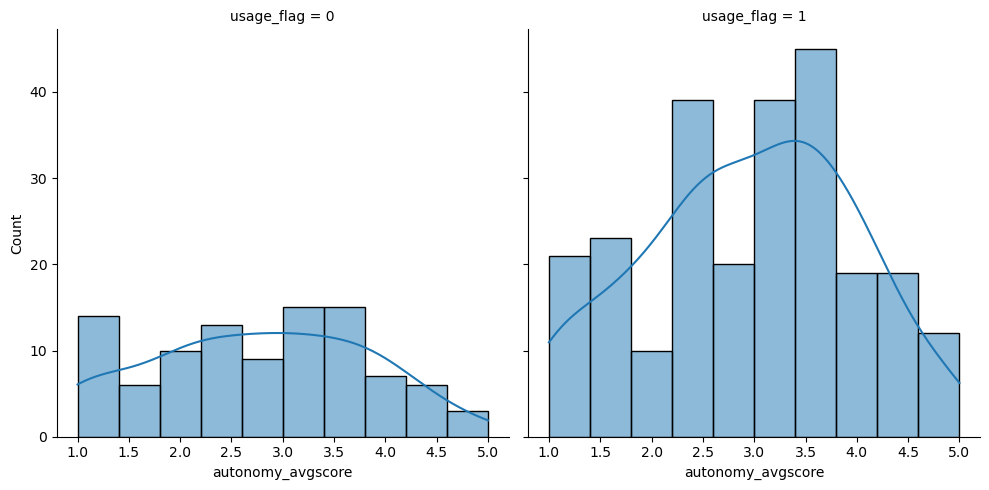

In [180]:
# Negative scoring. The lower the more feeling of autonomy
usage_false_autonomy_avg = df[df['usage_flag'] == 0]['autonomy_avgscore']
usage_true_autonomy_avg = df[df['usage_flag'] == 1]['autonomy_avgscore']

print('Wellbeing no usage mean autonomy score =', usage_false_autonomy_avg.mean())
print('Wellbeing usage mean autonomy score =', usage_true_autonomy_avg.mean())

sns.displot(data=df, x='autonomy_avgscore', col='usage_flag', kde=True)

In [195]:
# Chekc if variacnes are the same
print(np.var(np.random.choice(usage_true_autonomy_avg, size=len(usage_false_autonomy_avg), replace=False)))
print(np.var(usage_false_autonomy_avg))

nan
1.0994637650978758


In [202]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

stats.ttest_ind(  a=np.array(usage_false_autonomy_avg)
                , b=np.random.choice(usage_true_autonomy_avg, size=len(usage_false_autonomy_avg), replace=False)
                , equal_var=False
                , nan_policy='omit'
                , alternative='less')

# This means that those who do NOT use wellbeing features feel more autonomy than those who do use wellbeing features

Ttest_indResult(statistic=-0.27042063613403156, pvalue=0.3935608462881264)

### Competence

Wellbeing no usage mean competence score = 1.8365000000000002
Wellbeing usage mean competence score = 2.009196787148594


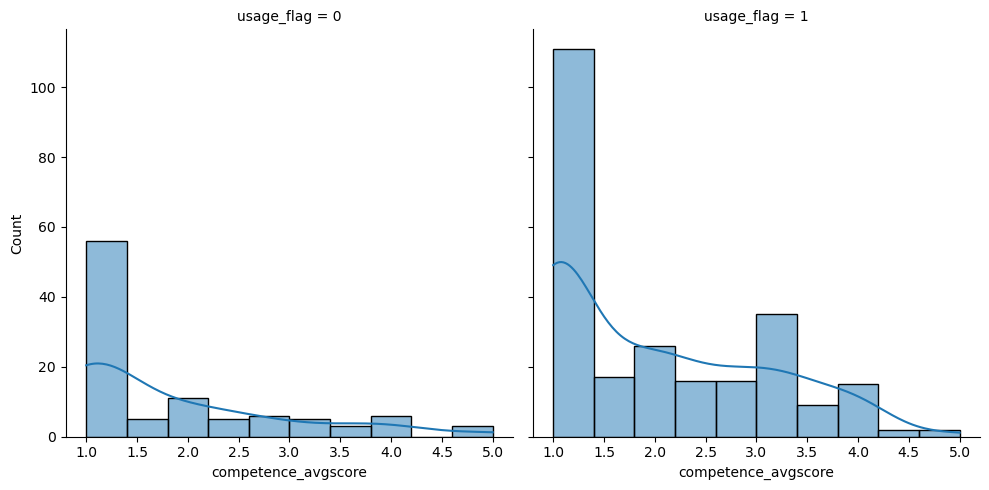

In [157]:
# Negative scoring. The lower the more feeling of competence
usage_false_competence_avg = df[df['usage_flag'] == 0]['competence_avgscore']
usage_true_competence_avg = df[df['usage_flag'] == 1]['competence_avgscore']

print('Wellbeing no usage mean competence score =', usage_false_competence_avg.mean())
print('Wellbeing usage mean competence score =', usage_true_competence_avg.mean())

sns.displot(data=df, x='competence_avgscore', col='usage_flag', kde=True)

In [179]:
# Chekc if variacnes are the same
print(np.var(np.random.choice(usage_true_competence_avg, size=len(usage_false_competence_avg), replace=False)))
print(np.var(usage_false_competence_avg))

1.1941582468281429
1.16400475


In [177]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

stats.ttest_ind(  a=np.array(usage_false_competence_avg)
                , b=np.random.choice(usage_true_competence_avg, size=len(usage_false_competence_avg), replace=False)
                , equal_var=False
                , nan_policy='omit'
                , alternative='less')

# This means that those who do NOT use wellbeing features feel more competence than those who do use wellbeing features

Ttest_indResult(statistic=-0.8665310049269535, pvalue=0.19362248938118454)

### Relatedeness

Wellbeing no usage mean relatedness score = 3.6239000000000003
Wellbeing usage mean relatedness score = 3.8633466135458163


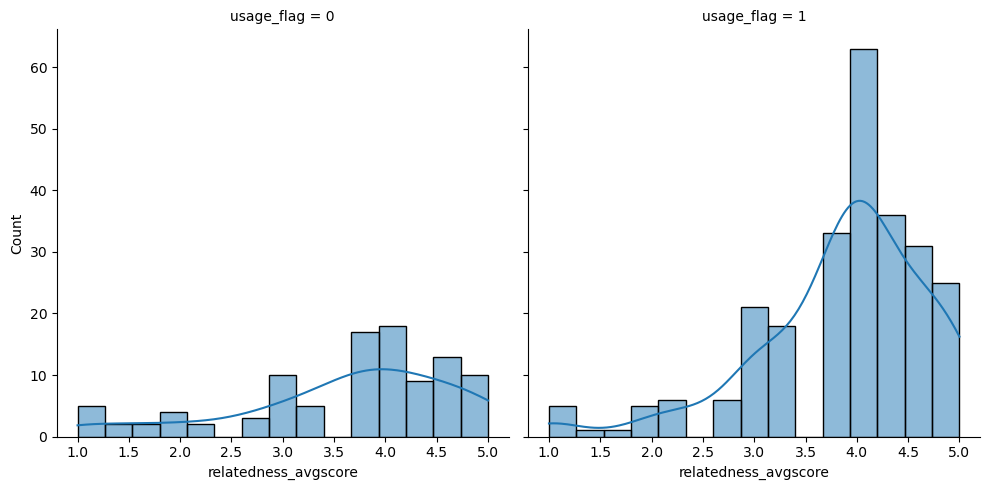

In [130]:
# Positive scoring. Higher the number the more feeling of relatedness
usage_false_relatedness_avg = df[df['usage_flag'] == 0]['relatedness_avgscore']
usage_true_relatedness_avg = df[df['usage_flag'] == 1]['relatedness_avgscore']

print('Wellbeing no usage mean relatedness score =', usage_false_relatedness_avg.mean())
print('Wellbeing usage mean relatedness score =', usage_true_relatedness_avg.mean())

sns.displot(data=df, x='relatedness_avgscore', col='usage_flag', kde=True)


In [152]:
# Chekc if variacnes are the same
print(np.var(np.random.choice(usage_true_relatedness_avg, size=len(usage_false_relatedness_avg), replace=False)))
print(np.var(usage_false_relatedness_avg))

0.6178198096885814
1.1376657900000002


In [151]:
# Use Welch's T-test (which does not assume same variance) on usage flag populations to see if there is a significant difference
# between the means of the population and that the false usage distribution mean is less than the true usage distribution mean

stats.ttest_ind(  a=np.array(usage_false_relatedness_avg)
                , b=np.random.choice(usage_true_relatedness_avg, size=len(usage_false_relatedness_avg), replace=False)
                , equal_var=False
                , nan_policy='omit'
                , alternative='less')

# This means that people who use wellbeing features feel more relatedness than those who do not use wellbeing features

Ttest_indResult(statistic=-2.36545668716072, pvalue=0.009515280473338867)

# RQ 4
What are the motivations behind the adoption of smartphone wellbeing features?

In [ ]:
# Return the ACTA Score for people who used wellbeing features
df.loc[df['usage_flag'] == 1, ['autonomous_regulation_score', 'controlled_regulation_score', 'relative_autonomy_index' ]]